In [19]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis

# Load data

In [20]:
batch_num = 1
hidden_num = 5
step_num = 100
elem_num = 34
init_wins = 200

names = [str(x) for x in range(elem_num)] +["label"]
smtp = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/smtp.csv",names=names,skiprows=step_num*init_wins)
wins = smtp.shape[0]//step_num
test_set = smtp.iloc[:wins*batch_num*step_num,:-1]
labels =smtp.iloc[:wins*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(wins)]

In [21]:
labels[labels!="normal"] = "anomaly"

In [22]:
del smtp
del test_set

In [23]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[47, 60, 81, 118, 119, 120, 236, 261, 299, 319, 320, 321, 360, 400, 422, 484, 503, 566, 567, 568, 569, 571, 589, 590, 591, 597, 659, 699, 700, 701, 740, 741]


# Load Model

In [24]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/smtp_multivariate/"
modelmeta_p = modelpath_root + "_1_5_100_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/smtp_multivariate/_1_5_100_para.ckpt


In [25]:
print(mu.shape,sigma.shape,threshold)

(34,) (34, 34) 0.0677892


# Online Phase (With expert)

In [26]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [27]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score,label):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        __thresold = scores.min()
        f = 0
        for t in range(int(scores.min()*100),int(scores.max()*100),5):
            fbeta,_, _ = evaluate(t/100,score,label)
            __thresold = t/100 if fbeta>f else __thresold
            
        threshold = threshold*eta + __thresold*(1-eta)
        return mu,sigma,threshold

In [28]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [49]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        
        (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
       
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        output += [1/x for x in scores]
    
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        
        for index,value in enumerate(pred):
            box.append(value)
            if value[value>threshold].size>=20: 
                if label[index] == "anomaly":
                    #print("TN")                 
                    a_buf.append(data[index])                  
                else:
                    #print("FN")                    
                    n_buf.append(data[index])
            else:               
                if label[index] == "anomaly":             
                    #print("FP")
                    a_buf.append(data[index])
                else:
                    #print("TP")
                    pass
        count +=1
        n_buf = box

        
        if count ==500:
            print("retrain...")
            loss_list_all=[]
            for i in range(50):
                buff = n_buf[::-1]
                loss_list=[]
                for _ in range(len(n_buf)):
                    
                    dl =[]
                    for _ in range(batch_num):
                        dl.append(buff.pop())
                    dl = np.array(dl).reshape(batch_num,step_num,elem_num)
                    
                    (loss, _) = sess.run([loss_, train_], {p_input: dl,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean())    
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(labels, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

retrain...


ValueError: cannot reshape array of size 100 into shape (1,100,34)

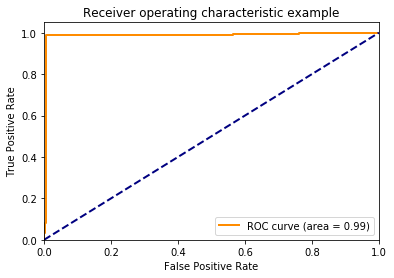

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(labels, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)

plot_roc(fpr,tpr,auc)


plt.show()